# Troll Classification

My overall project objective is to determine whether I can accurately predict whether a given tweet is from Donald Trump or a troll. This is a classification problem, but I'm assuming I'll need to rely heavily on NLP to interpret the payload of the tweet itself, and to generate some features that will prove useful in classification

Ahead of time, and to help me keep focused, I'm working through the problem this way

Pre-Notebook - Defining the business problem (this is contained within the lightning talk)
Book One - Data Acquisition, Cleaning & Initial EDA
Book Two - Enhanced EDA, NLP (to generate features), Classifiers
Bonus - To determine whether there are sentiment or content shifts over time

# Book 1: Acquire & Clean Data, First Stage of EDA

My section objective here is to develop a single dataframe, with columns that are common across Trump and Troll data. I'll then move into EDA on this single joined dataset

In [1]:
#not massively efficient use of memory to move all of this into the name space, but i prefer to declare 
#dependencies explicitly and do so up here at the top assuming someone else will need to read or use my code one day

import pandas as pd
import xml.etree.ElementTree as ET #in case I do need to revert to XML, which looked likely at one point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
#haven't pulled sklearn up here as it's such a large library

%matplotlib inline

In [2]:
! pwd

/Users/garysanders/Desktop/my_repo/unit_projects


### 1.1 Trump Dataset
My raw dataset is ~35k records from http://www.trumptwitterarchive.com/archive. There's no formal data dictionary available at the source, but the data is available as CSV or XML format. I've chosen CSV so I can spend my time on the data, rather than loading it, though I did start trying to learn XML parsing and may return to it if I have time. Twitter data is limited in nature, by design so this first stage is going to be little more than making sure I can generate clean columns separating the meta-data from the tweet itself

Trump and his advisors use a range of twitter handles. I've chosen to focus on @realdonaldtrump as it's generally recognised as 'his' twitter feed - i.e. contains tweets from Trump himself. There are also official Presidential accounts, but these tend to be msnaged by staff at the White House. Because this will contain secondary information, and will no doubt have been reviewed and checked many times it'll make my project too simple - I'll be comparing a troll dataset with a press office. Instead, I want to develop a classifier that works on more 'real' looking data

During the period that the data covers, Trump moved between TV personality, presidential candidate and then president. If I have time I'd like to determine whether the content and/or sentiment evolved over the period
    

In [3]:
#first to acquire the trump data. lots of errors in the initial load process, so I've 
#disabled errors and warnings. I might regret this later on, let's see

trump = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/Trump.csv", 
    sep=";", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [4]:
trump.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,We have been working hard on this - and it’s o...,11-29-2018 22:47:59,1531.0,5054,false,1.068275e+18
1,Twitter for iPhone,With all of the new books coming out you can't...,11-29-2018 22:43:12,1990.0,6896,false,1.068274e+18
2,Twitter for iPhone,".@DBongino’s new book, ""Spygate: The Attempted...",11-29-2018 22:34:18,3177.0,10929,false,1.068272e+18
3,Twitter for iPhone,....They have really done a great job in captu...,11-29-2018 22:14:22,2257.0,8304,false,1.068267e+18
4,Twitter for iPhone,".@StephenMoore and Arthur Laffer, two very tal...",11-29-2018 22:14:21,2981.0,11289,false,1.068267e+18


In [5]:
trump.info()
#I'll correct the datatype on the favourite_count column, changing the data to float64 format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30778 entries, 0 to 30777
Data columns (total 7 columns):
source            30778 non-null object
text              30777 non-null object
created_at        30774 non-null object
retweet_count     30774 non-null float64
favorite_count    30774 non-null object
is_retweet        30774 non-null object
id_str            30771 non-null float64
dtypes: float64(2), object(5)
memory usage: 1.6+ MB


In [6]:
trump.isna().sum()
#a small enough number of nulls to justify individual viewing and correction

source            0
text              1
created_at        4
retweet_count     4
favorite_count    4
is_retweet        4
id_str            7
dtype: int64

In [7]:
trump.loc[trump.isnull().any(axis=1)]
#based on a visual of the content, and the fact that this is 7 rows from a dataframe of 30774, I'm going to remove the row if 
#there's a null value anywhere

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
30255,TweetDeck,My interview which recently aired on CNBC's Sq...,NaN,NaN,NaN,NaN,NaN
30256,My in… (cont) http://t.co/YNX1msYh,09-19-2011 17:54:28,18,7.0,false,115846232714391552,NaN
30379,TweetDeck,http://goo.gl/AMNEE Countdown to @AmericaNowRa...,NaN,NaN,NaN,NaN,NaN
30380,#Apprentice Andy and I talk about politics an…...,08-09-2011 19:33:31,20,3.0,false,101013255950053376,NaN
30403,TweetDeck,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN
30404,http://bit.ly/pwgGsQ,NaN,NaN,NaN,NaN,NaN,NaN
30405,My interview yesterday on CNBC's Squawk Box...,08-02-2011 19:56:31,13,12.0,false,98482327390396416,NaN


In [8]:
trump.dropna(inplace=True)

In [9]:
trump.isna().sum() #it worked!

source            0
text              0
created_at        0
retweet_count     0
favorite_count    0
is_retweet        0
id_str            0
dtype: int64

In [10]:
#i'm going to drop the source column, and re-order
trump.drop('source', axis=1, inplace=True)

In [11]:
trump.dtypes

text               object
created_at         object
retweet_count     float64
favorite_count     object
is_retweet         object
id_str            float64
dtype: object

In [12]:
#i'm going to fix the created_at column to a date time format

trump_date = pd.to_datetime(trump['created_at'], errors='coerce', format='%m-%d-%Y %H:%M:%S')
trump_date.head()

0   2018-11-29 22:47:59
1   2018-11-29 22:43:12
2   2018-11-29 22:34:18
3   2018-11-29 22:14:22
4   2018-11-29 22:14:21
Name: created_at, dtype: datetime64[ns]

In [13]:
#creating a dataframe out of my series, and re-labelling my column so I don't have duplicate column labels on merge
trump_date2 = pd.DataFrame(trump_date)
trump_date2.rename(columns={'created_at' : 'create_date'}, inplace=True)

In [14]:
#now merging the dataframes
trump2 = pd.concat([trump, trump_date2], axis=1)
trump2.head(3)

,text,created_at,retweet_count,favorite_count,is_retweet,id_str,create_date
0,We have been working hard on this - and it’s o...,11-29-2018 22:47:59,1531.0,5054,false,1.068275e+18,2018-11-29 22:47:59
1,With all of the new books coming out you can't...,11-29-2018 22:43:12,1990.0,6896,false,1.068274e+18,2018-11-29 22:43:12
2,".@DBongino’s new book, ""Spygate: The Attempted...",11-29-2018 22:34:18,3177.0,10929,false,1.068272e+18,2018-11-29 22:34:18


In [15]:
trump2.shape

(30771, 7)

In [16]:
#removing my 'old' date column
trump2.drop('created_at',axis=1,inplace=True)

In [17]:
#visualisation on text format data is limited because most information is in the text content. however, let's have 
#a look at tweet behaviour over time by visualising the frequency of tweets over time, and 
#whether they increase or decrease

trump2['year'], trump2['month'] = trump2['create_date'].dt.year, trump2['create_date'].dt.month
trump2.head(3)

,text,retweet_count,favorite_count,is_retweet,id_str,create_date,year,month
0,We have been working hard on this - and it’s o...,1531.0,5054,false,1.068275e+18,2018-11-29 22:47:59,2018,11
1,With all of the new books coming out you can't...,1990.0,6896,false,1.068274e+18,2018-11-29 22:43:12,2018,11
2,".@DBongino’s new book, ""Spygate: The Attempted...",3177.0,10929,false,1.068272e+18,2018-11-29 22:34:18,2018,11


Text(0.5, 0, '# of Tweets')

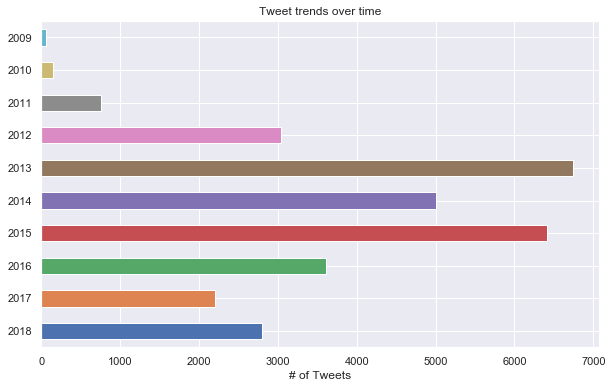

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
 
trump2.year.value_counts().sort_index(ascending=False).plot("barh", ax=ax)

ax.set_title("Tweet trends over time")
ax.set_xlabel("# of Tweets")

This surprised me, the number of tweets seems to have dropped since he moved into office. this is the main twitter
account (the white house @potus handle is used, but not by Trump himself). Evidently his tweets are much more newsworthy since he become president (he was elected on Nov 8th 2016)

In [19]:
#continuing to change data types. had initially planned to use pd to numeric, but wanted to be explicit 
#about the target data type. changed from float to int following Jose's feedback!

trump2 = trump2.astype({"favorite_count": int})

0.9073620744140548 0.0


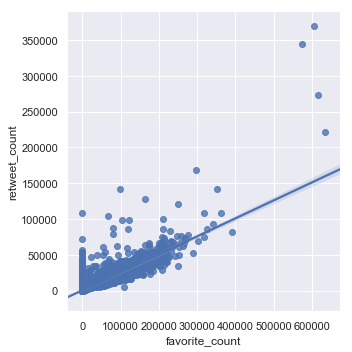

In [20]:
#It's hard to generate a meaningful set of visualisations from tweets, but for the sake of interest in the 
#data I'll have a look at whether tweet times are in any way correlated with retweet or favourite counts. There 
#appears

from scipy import stats
sns.lmplot ('favorite_count','retweet_count',trump2);

corr, p_value = stats.pearsonr(trump2["favorite_count"], trump2["retweet_count"])
print(corr, p_value)

#there's an apparently strong correlation (0.907) but it's not significant (p value <0.001). I'd 
#imagine using these two values in a prediction would end up generating multi-collinearity

In [21]:
#I'm now going to go through a number of steps to shrink and relabel the columns in my data frame, to make 
#concatenating it with the troll dataframe much more straightforward
trump2.rename(columns={'text':'tweet','favorite_count':'favourite_count','id_str': 'id'}, inplace=True)

In [22]:
trump2.head(3)

,tweet,retweet_count,favourite_count,is_retweet,id,create_date,year,month
0,We have been working hard on this - and it’s o...,1531.0,5054,false,1.068275e+18,2018-11-29 22:47:59,2018,11
1,With all of the new books coming out you can't...,1990.0,6896,false,1.068274e+18,2018-11-29 22:43:12,2018,11
2,".@DBongino’s new book, ""Spygate: The Attempted...",3177.0,10929,false,1.068272e+18,2018-11-29 22:34:18,2018,11


In [23]:
#re-ordering columns
trump3 = trump2[['id','tweet','create_date','is_retweet']]
trump3.head(2)

,id,tweet,create_date,is_retweet
0,1.068275e+18,We have been working hard on this - and it’s o...,2018-11-29 22:47:59,false
1,1.068274e+18,With all of the new books coming out you can't...,2018-11-29 22:43:12,false


In [24]:
#last checks
trump3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30771 entries, 0 to 30777
Data columns (total 4 columns):
id             30771 non-null float64
tweet          30771 non-null object
create_date    30771 non-null datetime64[ns]
is_retweet     30771 non-null object
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.2+ MB


In [25]:
#last checks
trump3.is_retweet.value_counts()

false    29943
true       828
Name: is_retweet, dtype: int64

In [26]:
#encoding the true/false variable for use in classification
trump3.is_retweet.replace ({'false':'0' , 'true':'1'},inplace=True)
trump3.is_retweet.value_counts()

0    29943
1      828
Name: is_retweet, dtype: int64

In [27]:
#changing the retweet flag into an integer, so it's better as a classifier, and merges with the troll data
trump3 = trump3.astype({"is_retweet": int})

In [28]:
trump3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30771 entries, 0 to 30777
Data columns (total 4 columns):
id             30771 non-null float64
tweet          30771 non-null object
create_date    30771 non-null datetime64[ns]
is_retweet     30771 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [29]:
#just spotted that my ID column is a float. not required for this purpose, so I'm casting it to an integer
trump3 = trump3.astype({"id": int})
trump3.dtypes

id                      int64
tweet                  object
create_date    datetime64[ns]
is_retweet              int64
dtype: object

In [30]:
#finally, adding a label that can act as a target when I merge the dataframes
trump3.loc[:, 'source'] = 'trump'
trump3.head()

,id,tweet,create_date,is_retweet,source
0,1068275406141149184,We have been working hard on this - and it’s o...,2018-11-29 22:47:59,0,trump
1,1068274204208812032,With all of the new books coming out you can't...,2018-11-29 22:43:12,0,trump
2,1068271965343862784,".@DBongino’s new book, ""Spygate: The Attempted...",2018-11-29 22:34:18,0,trump
3,1068266949115695104,....They have really done a great job in captu...,2018-11-29 22:14:22,0,trump
4,1068266944715878400,".@StephenMoore and Arthur Laffer, two very tal...",2018-11-29 22:14:21,0,trump


### 1.2 Trolls Datasets
My raw dataset contains over 3m records split across 13 files, which can be found at 35k records from https://github.com/fivethirtyeight/russian-troll-tweets/. The github folder also contains a data dictionary in the readme, which is copied below  

Column Header: Content Definition
- external_author_id: An author account ID from Twitter
- author: The handle sending the tweet
- content: The text of the tweet
- region: A region classification, as determined by Social Studio
- language: The language of the tweet
- publish_date: The date and time the tweet was sent
- harvested_date: The date and time the tweet was collected by Social Studio
- following: The number of accounts the handle was following at the time of the tweet
- followers: The number of followers the handle had at the time of the tweet
- updates: The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
- post_type: Indicates if the tweet was a retweet or a quote-tweet
- account_type: Specific account theme, as coded by Linvill and Warren
- retweet: A binary indicator of whether or not the tweet is a retweet
- account_category: General account theme, as coded by Linvill and Warren
- new_june_2018: A binary indicator of whether the handle was newly listed in June 2018
- alt_external_id: Reconstruction of author account ID from Twitter, derived from article_url variable and the first list provided to Congress
- tweet_id: Unique id assigned by twitter to each status update, derived from article_url
- article_url: Link to original tweet. Now redirects to "Account Suspended" page
- tco1_step1: First redirect for the first http(s)://t.co/ link in a tweet, if it exists
- tco2_step1: First redirect for the second http(s)://t.co/ link in a tweet, if it exists
- tco3_step1: First redirect for the third http(s)://t.co/ link in a tweet, if it exists

In [31]:
#starting with one troll file, to see what the data looks like. i've cycled through all of the files, but 
#have deleted some of the basic EDA cells here as it's repitition of what's above in the Trump data

troll_1 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_1.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [32]:
troll_1.describe()

,external_author_id,following,followers,updates,retweet,new_june_2018,alt_external_id,tweet_id
count,2.438910e+05,243891.000000,243891.000000,243891.000000,243891.000000,243891.000000,2.438910e+05,2.438910e+05
mean,2.406736e+17,2008.342079,2256.398219,6433.557208,0.633857,0.208913,2.406777e+17,7.809279e+17
std,3.921357e+17,3625.387602,4781.906074,9520.379342,0.481750,0.406533,3.921440e+17,9.915623e+16
min,3.497640e+07,0.000000,0.000000,1.000000,0.000000,0.000000,3.497640e+07,5.379085e+17
25%,1.679279e+09,149.000000,140.000000,1052.000000,0.000000,0.000000,1.679279e+09,6.782264e+17
50%,2.500690e+09,939.000000,611.000000,2759.000000,1.000000,0.000000,2.500690e+09,8.032465e+17
75%,8.390000e+17,2284.000000,2186.000000,7603.000000,1.000000,0.000000,8.386827e+17,8.602270e+17
max,9.681310e+17,21843.000000,23890.000000,70028.000000,1.000000,1.000000,9.681307e+17,9.766389e+17


In [33]:
troll_1.head(2)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN


I'm comfortable that the data is ready for acquisition, so the cells below bring the different files in, and then 
merge into a single, sizeable dataframe. I have investigated Dask and glob, as Jose suggested, but managed to wreck 
my machine in trying to install Dask. As such, I've reverted to pd_read and will retire to lick my wounds!

In [34]:
troll_2 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_2.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [35]:
troll_3 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_3.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [36]:
troll_4 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_4.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [37]:
troll_5 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_5.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [38]:
troll_6 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_6.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [39]:
troll_7 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_7.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [40]:
troll_8 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_8.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [41]:
troll_9 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_9.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [42]:
troll_10 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_10.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [43]:
troll_11 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_11.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [44]:
troll_12 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_12.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [45]:
troll_13 = pd.read_csv("/Users/garysanders/Desktop/my_repo/unit_projects/data/IRAhandle_tweets_13.csv", 
    sep=",", 
    error_bad_lines=False, 
    warn_bad_lines=False
    )

In [46]:
troll = pd.concat([troll_1,troll_2,troll_3,troll_4,troll_5,troll_6,troll_7,troll_8,troll_9,troll_10,troll_11,troll_12,troll_13],axis=0)
troll.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN


In [47]:
#checking for null values first. i'll come back to it when I've merged and re-ordered the data to see 
#what clean up is needed
troll.isna().sum()

external_author_id          0
author                      0
content                     1
region                   8818
language                    0
publish_date                0
harvested_date              0
following                   0
followers                   0
updates                     0
post_type             1648625
account_type                0
retweet                     0
account_category            0
new_june_2018               0
alt_external_id             0
tweet_id                    0
article_url                 0
tco1_step1             845971
tco2_step1            2235090
tco3_step1            2931207
dtype: int64

In [48]:
troll.account_type.value_counts()
#i'm curious about this variable, but I'll strip it out for the troll vs trump activity as it's a 
#clear indicator of being in the troll-only dataset. If I have time, I'll come back to this as a bonus exercise

Right         711668
Russian       704917
local         459220
Left          427141
Hashtager     241786
news          139006
Commercial    121904
German         91511
Italian        15680
?              13539
Koch           10894
Arabic          6228
Spanish         1226
French          1117
ZAPOROSHIA       175
Portuguese       118
Ebola             71
Ukranian           4
Uzbek              2
Name: account_type, dtype: int64

In [49]:
troll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946207 entries, 0 to 20893
Data columns (total 21 columns):
external_author_id    object
author                object
content               object
region                object
language              object
publish_date          object
harvested_date        object
following             int64
followers             int64
updates               int64
post_type             object
account_type          object
retweet               int64
account_category      object
new_june_2018         int64
alt_external_id       object
tweet_id              int64
article_url           object
tco1_step1            object
tco2_step1            object
tco3_step1            object
dtypes: int64(6), object(15)
memory usage: 494.5+ MB


In [50]:
#fixing the data formats. Next up: datetime. the first time through my pd.to_datetime created almost 1.8m nulls, 
#and I'm guessing it's because there's not a standard format in the existing publish_date column. I have to 
#find those differences and fix them
troll.groupby(['publish_date']).count()


,external_author_id,author,content,region,language,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
publish_date,,,,,,,,,,,,,,,,,,,,
1/1/2013 16:16,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2015 13:07,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2015 14:22,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2015 1:53,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2015 21:22,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2015 2:37,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2016 0:00,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0
1/1/2016 0:01,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0
1/1/2016 0:03,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,0


In [51]:
#the dataframe is too large for me to see what all the variations might be. I'm going to run this function to 
#create a clean series, and then I'll piece it back together again. this is s-l-o-w

%time
troll['clean_date'] = troll.publish_date.apply(
    lambda x: pd.to_datetime(x).strftime('%d/%m/%Y %H:%M'))
troll.head(5)

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 74.1 µs


,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1,clean_date
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN,01/10/2017 19:58
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN,01/10/2017 22:43
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN,01/10/2017 22:50
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN,01/10/2017 23:52
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN,01/10/2017 02:13


In [52]:
troll.dtypes

external_author_id    object
author                object
content               object
region                object
language              object
publish_date          object
harvested_date        object
following              int64
followers              int64
updates                int64
post_type             object
account_type          object
retweet                int64
account_category      object
new_june_2018          int64
alt_external_id       object
tweet_id               int64
article_url           object
tco1_step1            object
tco2_step1            object
tco3_step1            object
clean_date            object
dtype: object

In [53]:
troll_date = pd.to_datetime(troll['clean_date'], errors='ignore', format='%d/%m/%Y %H:%M')
troll_date.head(2)

0   2017-10-01 19:58:00
1   2017-10-01 22:43:00
Name: clean_date, dtype: datetime64[ns]

In [54]:
#as with trump above, creating a dataframe, and re-labelling column to avoid duplicates on merge
troll_date2 = pd.DataFrame(troll_date)
troll_date2.rename(columns={'clean_date' : 'create_date'}, inplace=True)

In [55]:
#now merging the dataframes
troll2 = pd.concat([troll, troll_date2], axis=1)
troll2.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1,clean_date,create_date
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN,01/10/2017 19:58,2017-10-01 19:58:00
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN,01/10/2017 22:43,2017-10-01 22:43:00
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN,01/10/2017 22:50,2017-10-01 22:50:00
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN,01/10/2017 23:52,2017-10-01 23:52:00
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN,01/10/2017 02:13,2017-10-01 02:13:00


In [56]:
troll2.columns

Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1', 'clean_date', 'create_date'],
      dtype='object')

In [57]:
#removing my 'old' date column
troll2.drop('publish_date',axis=1,inplace=True)

In [58]:
troll2.rename(columns={'content': 'tweet', 
                       'retweet': 'is_retweet',  
                       'tweet_id': 'id'
                      }, inplace=True)      

In [59]:
troll2.describe()

,following,followers,updates,is_retweet,new_june_2018,id
count,2.946207e+06,2.946207e+06,2.946207e+06,2.946207e+06,2.946207e+06,2.946207e+06
mean,3.448728e+03,7.055265e+03,1.051469e+04,4.404246e-01,2.095691e-01,7.603699e+17
std,5.625644e+03,1.463594e+04,1.770555e+04,4.964382e-01,4.070012e-01,9.648852e+16
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.648696e+17
25%,3.350000e+02,3.220000e+02,1.809000e+03,0.000000e+00,0.000000e+00,6.735990e+17
50%,1.506000e+03,1.274000e+03,4.361000e+03,0.000000e+00,0.000000e+00,7.766886e+17
75%,4.746000e+03,1.085300e+04,1.234300e+04,1.000000e+00,0.000000e+00,8.387258e+17
max,7.621000e+04,2.512760e+05,1.661130e+05,1.000000e+00,1.000000e+00,1.001932e+18


In [60]:
troll2.dtypes
#i need to make my column order: id, tweet, create_date, is retweet and make sure my data types match with trump above

external_author_id            object
author                        object
tweet                         object
region                        object
language                      object
harvested_date                object
following                      int64
followers                      int64
updates                        int64
post_type                     object
account_type                  object
is_retweet                     int64
account_category              object
new_june_2018                  int64
alt_external_id               object
id                             int64
article_url                   object
tco1_step1                    object
tco2_step1                    object
tco3_step1                    object
clean_date                    object
create_date           datetime64[ns]
dtype: object

In [61]:
#as with trump above, creating month and year columns so I can visualise when the tweet activity took place

troll2['year'], troll2['month'] = troll2['create_date'].dt.year, troll2['create_date'].dt.month
troll2.head(3)

,external_author_id,author,tweet,region,language,harvested_date,following,followers,updates,post_type,...,alt_external_id,id,article_url,tco1_step1,tco2_step1,tco3_step1,clean_date,create_date,year,month
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:59,1052,9636,253,NaN,...,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN,01/10/2017 19:58,2017-10-01 19:58:00,2017,10
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,1054,9637,254,NaN,...,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN,01/10/2017 22:43,2017-10-01 22:43:00,2017,10
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:51,1054,9637,255,RETWEET,...,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN,01/10/2017 22:50,2017-10-01 22:50:00,2017,10


Text(0.5, 0, '# of Tweets')

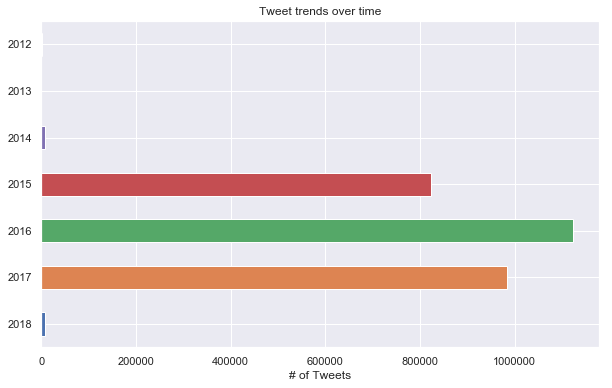

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))
 
troll2.year.value_counts().sort_index(ascending=False).plot("barh", ax=ax)

ax.set_title("Tweet trends over time")
ax.set_xlabel("# of Tweets")

#this surprised me, the duration of the troll activity runs for a short time up to and 
#including Trump's election and his first year It then drops sharply. For now I'll assume 
#that this is because the trolls were discovered and shut down, but I need to check my facts on that

In [63]:
#stripping out columns so my dataframe matches the structure of the trump data, ready for concatenation
troll2.drop(['external_author_id',
       'harvested_date','following','followers','updates','region','language',
       'post_type','account_type','account_category','author',
       'new_june_2018','alt_external_id','article_url',
       'tco1_step1','tco2_step1','tco3_step1'], axis=1, inplace=True)
troll2.head()

,tweet,is_retweet,id,clean_date,create_date,year,month
0,"""We have a sitting Democrat US Senator on tria...",0,914580356430536707,01/10/2017 19:58,2017-10-01 19:58:00,2017,10
1,Marshawn Lynch arrives to game in anti-Trump s...,0,914621840496189440,01/10/2017 22:43,2017-10-01 22:43:00,2017,10
2,Daughter of fallen Navy Sailor delivers powerf...,1,914623490375979008,01/10/2017 22:50,2017-10-01 22:50:00,2017,10
3,JUST IN: President Trump dedicates Presidents ...,0,914639143690555392,01/10/2017 23:52,2017-10-01 23:52:00,2017,10
4,"19,000 RESPECTING our National Anthem! #StandF...",1,914312219952861184,01/10/2017 02:13,2017-10-01 02:13:00,2017,10


In [64]:
#re-ordering columns in the dataframe, again so they match the trump dataframe
troll2 = troll2[['id','tweet','create_date','is_retweet']]
troll2.head()

,id,tweet,create_date,is_retweet
0,914580356430536707,"""We have a sitting Democrat US Senator on tria...",2017-10-01 19:58:00,0
1,914621840496189440,Marshawn Lynch arrives to game in anti-Trump s...,2017-10-01 22:43:00,0
2,914623490375979008,Daughter of fallen Navy Sailor delivers powerf...,2017-10-01 22:50:00,1
3,914639143690555392,JUST IN: President Trump dedicates Presidents ...,2017-10-01 23:52:00,0
4,914312219952861184,"19,000 RESPECTING our National Anthem! #StandF...",2017-10-01 02:13:00,1


In [65]:
#adding a troll identifier so I have labels
troll2.loc[:, 'source'] = 'troll'
troll2.head()

,id,tweet,create_date,is_retweet,source
0,914580356430536707,"""We have a sitting Democrat US Senator on tria...",2017-10-01 19:58:00,0,troll
1,914621840496189440,Marshawn Lynch arrives to game in anti-Trump s...,2017-10-01 22:43:00,0,troll
2,914623490375979008,Daughter of fallen Navy Sailor delivers powerf...,2017-10-01 22:50:00,1,troll
3,914639143690555392,JUST IN: President Trump dedicates Presidents ...,2017-10-01 23:52:00,0,troll
4,914312219952861184,"19,000 RESPECTING our National Anthem! #StandF...",2017-10-01 02:13:00,1,troll


In [66]:
#checking data types match up with trump. they do!
troll2.dtypes

id                      int64
tweet                  object
create_date    datetime64[ns]
is_retweet              int64
source                 object
dtype: object

In [67]:
#finally a quick check of distributions on the re-tweet field so I know how many we have, 
#before downsampling. I'm going to look for and remove nulls before dataframe concatenation
troll2.is_retweet.value_counts()

0    1648625
1    1297582
Name: is_retweet, dtype: int64

In [68]:
#last check that we've gotten rid of the NaN values in the time series field. we have, finally!
troll2.isna().sum()

id             0
tweet          1
create_date    0
is_retweet     0
source         0
dtype: int64

In [69]:
#getting rid of the single that contains NaNs
troll2.dropna(inplace=True)

### 1.3 Merging the dataframes and downsampling

I have a massive class imbalance problem: 2,946,207 troll samples and 30,771 trump samples. My data is 
around 99% troll class. I could give up on a model and just guess troll and I'd be 99% accurate (but 
with a useless model). Given the nature of the text payload, i can't upsample tweets (easily!) so 
i'll have to downsample the majority class

In [70]:
#reducing the size of the dataframe so I don't have such an inbalanced class problem. I'm going to aim 
#for 40k troll tweets, spread across the period

troll3 = troll2.sample(n=40000, random_state=21)
troll3.head()

,id,tweet,create_date,is_retweet,source
4849,890610842969952257,This Democrat might be Cuomo’s biggest challen...,2017-07-27 16:32:00,0,troll
173141,804917726154203137,Strange things are afoot at the @SuperHeroSpea...,2016-12-03 05:18:00,1,troll
228998,904409763164905474,BREAKING VIDEO : Hurricane Irma Gaining Steam ...,2017-09-03 18:24:00,0,troll
182184,787424421195546626,Officers shot in West Philly rampage honored a...,2016-10-15 22:46:00,0,troll
87394,609845070406119424,This is what happens when you pour Coke into m...,2015-06-13 22:09:00,1,troll


In [71]:
#checking nothing too alarming given my downsample to 40k
troll3.shape

(40000, 5)

In [72]:
#last check to make sure it's clean for merge
troll3.head(3)

,id,tweet,create_date,is_retweet,source
4849,890610842969952257,This Democrat might be Cuomo’s biggest challen...,2017-07-27 16:32:00,0,troll
173141,804917726154203137,Strange things are afoot at the @SuperHeroSpea...,2016-12-03 05:18:00,1,troll
228998,904409763164905474,BREAKING VIDEO : Hurricane Irma Gaining Steam ...,2017-09-03 18:24:00,0,troll


In [73]:
#resetting my troll index
troll3.reset_index(inplace=True)

In [74]:
#last check to make sure it's clean for merge
trump3.head(3)

,id,tweet,create_date,is_retweet,source
0,1068275406141149184,We have been working hard on this - and it’s o...,2018-11-29 22:47:59,0,trump
1,1068274204208812032,With all of the new books coming out you can't...,2018-11-29 22:43:12,0,trump
2,1068271965343862784,".@DBongino’s new book, ""Spygate: The Attempted...",2018-11-29 22:34:18,0,trump


In [75]:
#merging datasets and checking all is well with column headers after all the wrangling above
df = pd.concat([trump3,troll3], axis=0)
df.head()

,create_date,id,index,is_retweet,source,tweet
0,2018-11-29 22:47:59,1068275406141149184,NaN,0,trump,We have been working hard on this - and it’s o...
1,2018-11-29 22:43:12,1068274204208812032,NaN,0,trump,With all of the new books coming out you can't...
2,2018-11-29 22:34:18,1068271965343862784,NaN,0,trump,".@DBongino’s new book, ""Spygate: The Attempted..."
3,2018-11-29 22:14:22,1068266949115695104,NaN,0,trump,....They have really done a great job in captu...
4,2018-11-29 22:14:21,1068266944715878400,NaN,0,trump,".@StephenMoore and Arthur Laffer, two very tal..."


In [76]:
#resetting my index again following merge
df.reset_index(inplace=True)

In [77]:
#checking my target label distribution. all looks good, let's build some models at last!
df.source.value_counts()

troll    40000
trump    30771
Name: source, dtype: int64

In [78]:
df.head()

,level_0,create_date,id,index,is_retweet,source,tweet
0,0,2018-11-29 22:47:59,1068275406141149184,NaN,0,trump,We have been working hard on this - and it’s o...
1,1,2018-11-29 22:43:12,1068274204208812032,NaN,0,trump,With all of the new books coming out you can't...
2,2,2018-11-29 22:34:18,1068271965343862784,NaN,0,trump,".@DBongino’s new book, ""Spygate: The Attempted..."
3,3,2018-11-29 22:14:22,1068266949115695104,NaN,0,trump,....They have really done a great job in captu...
4,4,2018-11-29 22:14:21,1068266944715878400,NaN,0,trump,".@StephenMoore and Arthur Laffer, two very tal..."


In [79]:
#creating a file I can carry into Book 2 (to keep my kernel size under control)
#df.to_csv(encoding='utf-8')